In [97]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input

seed = 2023
np.random.seed(seed)  

In [132]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['accuracy']),'g-', 
             label='Train accuracy')
    plt.plot(xvals, np.array(history.history['val_accuracy']),'r-',
             label = 'Validation accuracy')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

### Read images

In [74]:
data_dir = "./data/stage1_train"
train_ids = os.listdir(data_dir)

X_train = np.zeros((len(train_ids), 128, 128, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), 128, 128, 1), dtype=np.bool_)

for i in range(len(train_ids)):
    sample_train = {}
    
    path_images = f"{data_dir}/{train_ids[i]}/images"
    filename_image = os.listdir(path_images)[0]
    image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
    image = tf.image.resize(image, [128, 128])
    X_train[i] = image
    
    path_mask = f"{data_dir}/{train_ids[i]}/combined_masks"
    filename_mask = os.listdir(path_mask)[0]
    mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
    mask = tf.image.resize(mask, [128, 128], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
    Y_train[i] = mask

In [135]:
data_dir = "./data/stage1_test"
test_ids = os.listdir(data_dir)

X_test = np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), 128, 128, 1), dtype=np.bool_)

sizes_test = []

for i in range(len(X_test)):
    path_images = f"{data_dir}/{test_ids[i]}/images"
    filename_image = os.listdir(path_images)[0]
    image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
    sizes_test.append(tf.shape(image))
    image = tf.image.resize(image, [128, 128])
    X_test[i] = image
    
    path_mask = f"{data_dir}/{test_ids[i]}/combined_masks"
    filename_mask = os.listdir(path_mask)[0]
    mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
    mask = tf.image.resize(mask, [128, 128], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
    Y_test[i] = mask

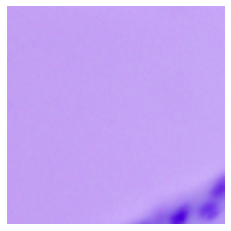

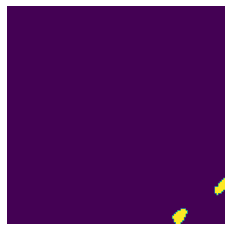

In [134]:
display_img(X_train[0])
display_img(Y_train[0])

In [156]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [160]:
def create_model(input_shape, LR):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=LR), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [164]:
batch_size = 32
batches_per_epoch = int(len(X_train)/batch_size) 
epochs = 50
LR = 0.0001
stopping_patience = 10
stopping_delta = 0.001

model = create_model((128, 128, 3), LR)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_145 (Conv2D)            (None, 128, 128, 64  1792        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 128, 128, 64  256        ['conv2d_145[0][0]']             
 Normalization)                 )                                                           

In [165]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     patience=stopping_patience, 
                                                     min_delta=stopping_delta,
                                                     verbose = 1,
                                                     restore_best_weights=True)

results = model.fit(X_train, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,  
                    validation_data=(X_test, Y_test),
                    callbacks = [stopping_callback],
                    shuffle=True)

Epoch 1/50
21/21 [==============================] - 7s 202ms/step - loss: 0.0000e+00 - accuracy: 0.7655 - val_loss: 0.0000e+00 - val_accuracy: 0.5283
Epoch 2/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.8842 - val_loss: 0.0000e+00 - val_accuracy: 0.7384
Epoch 3/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9081 - val_loss: 0.0000e+00 - val_accuracy: 0.8250
Epoch 4/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9261 - val_loss: 0.0000e+00 - val_accuracy: 0.8370
Epoch 5/50
21/21 [==============================] - 3s 136ms/step - loss: 0.0000e+00 - accuracy: 0.9387 - val_loss: 0.0000e+00 - val_accuracy: 0.8353
Epoch 6/50
21/21 [==============================] - 3s 139ms/step - loss: 0.0000e+00 - accuracy: 0.9466 - val_loss: 0.0000e+00 - val_accuracy: 0.8441
Epoch 7/50
21/21 [==============================] - 3s 140ms/step - loss: 0.0000e+00 - accuracy: 0.9

Training set Accuracy: 0.9643
Training set Loss:0.000000

Validation set Accuracy: 0.9287
Validation set Loss:0.000000



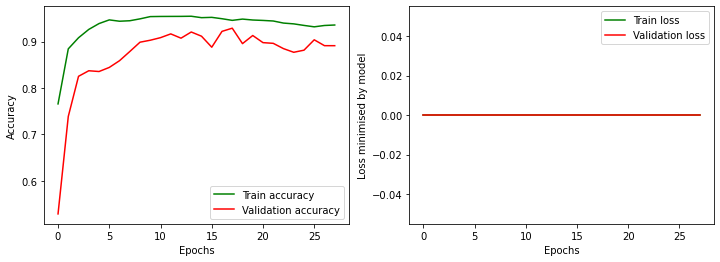

In [166]:
[train_loss, train_accuracy] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = model.evaluate(X_test, Y_test, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(results)

In [138]:
#idx = random.randint(0, len(X_train))
idx = 4
preds_train = modelUNet.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = modelUNet.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = modelUNet.predict(X_test, verbose=1)

3/3 [==============================] - 0s 39ms/step


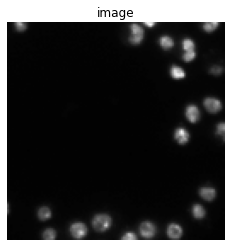

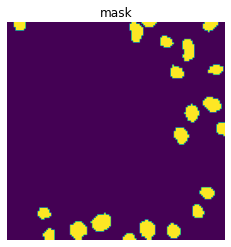

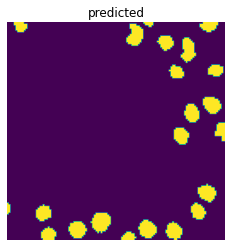

In [142]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

ix = random.randint(0, len(preds_val_t))

display_img(X_train[ix], title="image")
display_img(Y_train[ix], title="mask")
display_img(preds_train_t[ix], title="predicted")

In [124]:
ix

43